In [210]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,List,Annotated,Dict,Literal

In [211]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [212]:
from langchain_groq import ChatGroq
api_key=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model='llama-3.1-8b-instant',api_key=api_key)

In [213]:
from pydantic import BaseModel,Field

In [216]:
import operator

In [217]:
class TweetState(TypedDict):
    #input
    topic : str
    tweet : str

    #output
    evaluation : Literal["approved","needs_improovement"]
    feedback : str
    iteration : int
    max_iteration : int
    tweet_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add]

In [218]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [219]:
def generate_tweet(state : TweetState) -> TweetState:
    messages =[
        SystemMessage(content ="You are a funny and clever twitter influencer "),
        HumanMessage(content=f"""
                     Write a short , original, and hilarious tweet on the topic :"{state['topic']}"
                     Rules:
                     -Do not use question -answer format.
                     -Make sure tweet is less than 200 words.TextDisplayObject
                     -use obserrvational humor ,irony, sarcasm, cultural refrences
       """)
    ]

    response = llm.invoke(input=messages)

    return {'tweet' : response , 'tweet_history':[response]}

In [220]:
import json

#You're seeing double curly braces {{ ... }} because Python f-strings #escape curly braces by doubling them.

In [221]:
#.strip is important and also remove unnecessay things which may stop the ans to convert into json

In [222]:

def evaluate_tweet(state :TweetState) -> TweetState:
    messages = [
        SystemMessage(content  = "You are a strict tweet evaluator who provide honest feedback"),
        HumanMessage(content=f"""
            Evaluate the following tweet : {state['tweet']}
Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in JSON structured format:

- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
            """)
    ]
    response = llm.invoke(input=messages)
    print("response is ",response)
    print("response type is ",type(response))

    cleaned_text = response.content.strip()
    cleaned_text = cleaned_text.replace('`','')
    cleaned_text = cleaned_text.replace('json','')
    cleaned_text = cleaned_text.strip()
    print("ans evaluation is ", cleaned_text)

    try:
        ans = json.loads(cleaned_text)

    except json.JSONDecodeError:
        raise ValueError(f" failed to parse ans in json")
    return {'evaluation':ans["evaluation"], 'feedback':ans["feedback"],'feedback_histtory':[ans["feedback"]]}


In [223]:
def optimize_feedback(state : TweetState) -> TweetState:
    messages =[
        SystemMessage(content="You are a tweet optimizer who improves tweet based on the feedback"),
        HumanMessage(content=f"""
            Optimize the folllowing tweeet :{state['tweet']}. Use the following feedback to optimize it :{state['feedback']}.The topic for the tweet is :{state['topic']}
            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.

""")
    ]

    response = llm.invoke(input=messages)
    iteration = state['iteration']+1

    return {'tweet':response,'iteration':iteration,'tweet_history':[response]}

In [224]:
def route_evaluation(state : TweetState) -> TweetState:
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return  'approved'
    else:
        return 'needs_improvement'

In [225]:
graph = StateGraph(TweetState)

graph.add_node('generate_tweet_node',generate_tweet)
graph.add_node('evaluate_tweet_node',evaluate_tweet)
graph.add_node('optimize_feedback_node',optimize_feedback)
# graph.add_node('route_evaluation_node',route_evaluation)

graph.add_edge(START,'generate_tweet_node')
graph.add_edge('generate_tweet_node','evaluate_tweet_node')
#we are matching keyword from the output to the node names
graph.add_conditional_edges('evaluate_tweet_node',route_evaluation,{'approved':END,'needs_improvement':'optimize_feedback_node'})

# graph.add_conditional_edges('optimize_feedback_node',END)
graph.add_edge('optimize_feedback_node','evaluate_tweet_node')

In [226]:
workflow = graph.compile()
initial_state = {
    'topic':'samosa',
    'iteration':0,
    'max_iteration':3
}


In [227]:
final_state = workflow.invoke(initial_state)

response is  content='{\n  "evaluation": "approved",\n  "feedback": "This tweet is a great example of humor and lightheartedness. It starts off with a relatable scenario of consuming a samosa and suddenly becoming an expert on various unrelated topics, showcasing a clever play on the cliché \'expert after eating a particular food.\' The humor is genuine, and the punchline about calculating the caloric intake of the samosa is well-executed. The tweet is concise and well-formed, making it suitable for scrolling and sharing. However, it could benefit from a bit more punchiness, as the humor is slightly self-contained and might not be as impactful on a wider audience."\n}' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 562, 'total_tokens': 702, 'completion_time': 0.284082537, 'completion_tokens_details': None, 'prompt_time': 0.0662646, 'prompt_tokens_details': None, 'queue_time': 0.054024289, 'total_time': 0.350347137}, 'model_name': 'lla

In [228]:
from IPython.display import display,Image

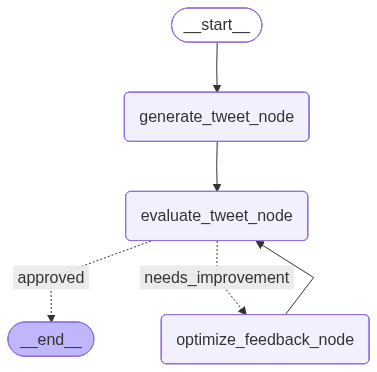

In [229]:
Image(workflow.get_graph().draw_mermaid_png())

In [230]:
final_state = workflow.invoke(initial_state, print_node=True)

response is  content='```json\n{\n  "evaluation": "approved",\n  "feedback": "This tweet is a delightful example of humor and creativity. It effectively uses wordplay, exaggeration, and self-deprecation to create a lighthearted and relatable tone. The mention of shedding tears because of forgetting raita adds a touch of endearment and makes the reader laugh. However, to further elevate the tweet, consider adding a bit more punchiness to the opening sentence to grab the reader\'s attention immediately. The use of hashtags, particularly #SamosaLove, is a nice touch and has the potential to attract new followers who share similar interests."\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 562, 'total_tokens': 698, 'completion_time': 0.282968761, 'completion_tokens_details': None, 'prompt_time': 0.037616972, 'prompt_tokens_details': None, 'queue_time': 0.059394307, 'total_time': 0.320585733}, 'model_name': 'llama-3.1-8b-instant', 

##the above code will print 
#Node name

#Input state to that node

#Output returned by that node

In [231]:
final_state

{'topic': 'samosa',
 'tweet': AIMessage(content='"Just had a samosa for lunch and I\'m convinced I\'ve single-handedly kept the Indian economy afloat. The crisp pastry, the spicy filling, the tears of joy I shed because I forgot to buy raita again... it\'s a national treasure, folks. #SamosaLove #NaanOfYourBusiness"', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 111, 'total_tokens': 179, 'completion_time': 0.142080767, 'completion_tokens_details': None, 'prompt_time': 0.007028487, 'prompt_tokens_details': None, 'queue_time': 0.049933882, 'total_time': 0.149109254}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b9947-fc1a-7541-9299-504a3edb6d21-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 111, 'output_tokens': 68, 'total_tokens': 179}),
 'evaluation': 'approved',

#This lets you see output live while the graph is running.

In [232]:
for step in workflow.stream(initial_state, print_stream=True):
    pass

response is  content='```json\n{\n  "evaluation": "approved",\n  "feedback": "This tweet effectively utilizes humor and originality to poke fun at the speaker\'s samosa obsession. The use of a \'love triangle\' metaphor adds a creative twist, making it engaging and memorable. However, the punchline could be even sharper, and the phrase \'Carb Coma Ahead\' feels slightly generic. Overall, the tweet is well-formed and within the 280-character limit, making it suitable for sharing and retweeting."\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 545, 'total_tokens': 652, 'completion_time': 0.184057279, 'completion_tokens_details': None, 'prompt_time': 0.040637675, 'prompt_tokens_details': None, 'queue_time': 0.055956005, 'total_time': 0.224694954}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run

In [233]:
workflow.stream(initial_state, print_stream=True)

<generator object Pregel.stream at 0x0000029CBF678C70>